# Define hyperparameters and graph strucutre

In [18]:
from tsplearn import *
import numpy as np 
import pandas as pd

# Load the graph
G = EnhancedGraph(n=40, p=0.162, seed=0)
B1 = G.get_b1()
B2 = G.get_b2()

# Sub-sampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1, dtype=float)
Lu = np.matmul(B2, np.transpose(B2), dtype=float)
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]

# Problem and Dictionary Dimensionalities
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s = 3 # Number of Kernels (Sub-dictionaries)
k = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

# Data-Independent Problem Hyperparameters
dictionary_type = ""
K0_coll = np.arange(5, 26, 4) 
max_iter = 100 
patience = 5 
tol = 1e-7 # tolerance for Patience
n_sim = 10
lambda_ = 1e-7 # l2 multiplier
verbose = True

# Synthetic data generation

In [27]:
from tqdm import tqdm

dictionary_type = "joint"

D_true = np.zeros((n, n * s, n_sim))
D_true_coll = np.zeros((n, n, s, n_sim))
Y_train = np.zeros((n, m_train, n_sim))
Y_test = np.zeros((n, m_test, n_sim))
epsilon_true = np.zeros(n_sim)
c_true = np.zeros(n_sim)
X_train = np.zeros((n * s, m_train, n_sim))
X_test = np.zeros((n * s, m_test, n_sim))
n_search = 3000

for sim in range(n_sim):
    best_sparsity = 0
    best_acc = 0

    for i in tqdm(range(n_search)):
        try:
            D_try, h, Y_train_try, Y_test_try, epsilon_try, c_try, X_train_try, X_test_try = create_ground_truth(Lu,
                                                                                    Ld,
                                                                                    m_train,
                                                                                    m_test, 
                                                                                    s=s, 
                                                                                    K=k, 
                                                                                    K0=K0_max, 
                                                                                    dictionary_type=dictionary_type, 
                                                                                    sparsity_mode=sparsity_mode)
            
            max_possible_sparsity, acc = verify_dic(D_try, Y_train_try, X_train_try, K0_max, .7)
            if max_possible_sparsity > best_sparsity:
                best_sparsity = max_possible_sparsity
                best_acc = acc
                D_true[:, :, sim] = D_try
                Y_train[:, :, sim] = Y_train_try
                Y_test[:, :, sim] = Y_test_try
                epsilon_true[sim] = epsilon_try
                c_true[sim] = c_try
                X_train[:, :, sim] = X_train_try
                X_test[:, :, sim] = X_test_try

        except Exception as e:
            print(f"Error during dictionary creation: {e}")
    if verbose:
        print(f"...Done! # Best Sparsity: {best_sparsity}")

100%|██████████| 3000/3000 [01:34<00:00, 31.78it/s]


...Done! # Best Sparsity: 4


100%|██████████| 3000/3000 [01:32<00:00, 32.56it/s]


...Done! # Best Sparsity: 4


100%|██████████| 3000/3000 [01:31<00:00, 32.78it/s]


...Done! # Best Sparsity: 4


100%|██████████| 3000/3000 [01:34<00:00, 31.84it/s]


...Done! # Best Sparsity: 4


100%|██████████| 3000/3000 [01:40<00:00, 29.76it/s]


...Done! # Best Sparsity: 5


100%|██████████| 3000/3000 [01:32<00:00, 32.40it/s]


...Done! # Best Sparsity: 4


100%|██████████| 3000/3000 [01:32<00:00, 32.56it/s]


...Done! # Best Sparsity: 4


100%|██████████| 3000/3000 [01:32<00:00, 32.30it/s]


...Done! # Best Sparsity: 5


100%|██████████| 3000/3000 [01:30<00:00, 33.27it/s]


...Done! # Best Sparsity: 5


100%|██████████| 3000/3000 [01:28<00:00, 33.80it/s]

...Done! # Best Sparsity: 5


# Dictionary learning

In [28]:
import warnings

warnings.filterwarnings('ignore')

min_error_fou_train = np.zeros((n_sim, len(K0_coll)))
min_error_fou_test = np.zeros((n_sim, len(K0_coll)))
min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
min_error_sep_test = np.zeros((n_sim, len(K0_coll)))
min_error_edge_train = np.zeros((n_sim, len(K0_coll)))
min_error_edge_test = np.zeros((n_sim, len(K0_coll)))
min_error_joint_train = np.zeros((n_sim, len(K0_coll)))
min_error_joint_test = np.zeros((n_sim, len(K0_coll)))

dict_errors = {
    "fou": (min_error_fou_train,min_error_fou_test),
    "edge": (min_error_edge_train,min_error_edge_test),
    "joint": (min_error_joint_train,min_error_joint_test),
    "sep": (min_error_sep_train,min_error_sep_test)
    }


dict_types = {
    "fou": ("Fourier","fourier"),
    "edge": ("Edge Laplacian", "edge_laplacian"),
    "joint": ("Hodge Laplacian","joint"),
    "sep": ("Separated Hodge Laplacian","separated")
    }

for sim in range(n_sim):
    c = c_true[sim]  
    epsilon = epsilon_true[sim] 
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        discard = 1
        while discard == 1:
            
            try:
                D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
            except:
                print("Initialization Failed!")

        for d in dict_types.items():
            try:
                dict_errors[d[0]][0][sim,k0_index], dict_errors[d[0]][1][sim,k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                            k, n, s, D0, X0, Lu, Ld, d[1][1],
                                                                                                                            c, epsilon, k0, lambda_, max_iter,
                                                                                                                            patience, tol)
                if verbose:
                    print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {d[1][0]}... Done! Test Error: {dict_errors[d[0]][1][sim,k0_index]}")
            except:
                print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {d[1][0]}... Diverged!')
                try:
                    dict_errors[d[0]][0][sim,k0_index], dict_errors[d[0]][1][sim,k0_index] = (dict_errors[d[0]][0][sim-1,k0_index]
                                                                                          , dict_errors[d[0]][1][sim-1,k0_index])
                except:
                    dict_errors[d[0]][0][sim,k0_index], dict_errors[d[0]][1][sim,k0_index] = (dict_errors[d[0]][0][sim+1,k0_index]
                                                                                          , dict_errors[d[0]][1][sim+1,k0_index])


0it [00:00, ?it/s]

Simulation: 1/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.33029265188139645
Simulation: 1/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.0843661115982034
Simulation: 1/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.03882762442310686


1it [00:57, 57.32s/it]

Simulation: 1/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.038822460346586936
Simulation: 1/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.20129502251893716
Simulation: 1/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.044640267953005054
Simulation: 1/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.010274589693192783


2it [02:05, 63.95s/it]

Simulation: 1/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.009934823409176969
Simulation: 1/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.13006187387870424
Simulation: 1/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.02398377029706421
Simulation: 1/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.004035496794442823


3it [03:29, 73.06s/it]

Simulation: 1/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.00398014212026995
Simulation: 1/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.09167016115509513
Simulation: 1/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.013648000745828372
Simulation: 1/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.0020931924899090064


4it [06:15, 109.73s/it]

Simulation: 1/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.0020967260459512135
Simulation: 1/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.06847365229367441
Simulation: 1/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.00849986856035419
Simulation: 1/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.0011708516640115748


5it [10:37, 164.44s/it]

Simulation: 1/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.0011242962034612562
Simulation: 1/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.05161751904678165
Simulation: 1/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.005218217093928572
Simulation: 1/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0010279928503709214


6it [15:51, 158.59s/it]


Simulation: 1/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.0011195365335139032


0it [00:00, ?it/s]

Simulation: 2/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.23666083790999004
Simulation: 2/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.08259410885471229
Simulation: 2/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.03090080928229306


1it [00:36, 37.00s/it]

Simulation: 2/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.035093165719215814
Simulation: 2/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.12908327488769009
Simulation: 2/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.0409617848701033
Simulation: 2/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.008119816020704133


2it [01:38, 51.66s/it]

Simulation: 2/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.009916288082915727
Simulation: 2/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.08272301823015629
Simulation: 2/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.02199320644881187
Simulation: 2/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.003733688708096744


3it [02:51, 61.09s/it]

Simulation: 2/10 Sparsity: 13 Testing Separated Hodge Laplacian... Diverged!
Simulation: 2/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.050567947962864596
Simulation: 2/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.012896671067662947
Simulation: 2/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.0023946911348497364


4it [05:55, 109.62s/it]

Simulation: 2/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.002075261634628046
Simulation: 2/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03299925469595504
Simulation: 2/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.007994660809538178
Simulation: 2/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.001347387826456916


5it [08:43, 130.83s/it]

Simulation: 2/10 Sparsity: 21 Testing Separated Hodge Laplacian... Diverged!
Simulation: 2/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.021658734136476475
Simulation: 2/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.009440710143658364
Simulation: 2/10 Sparsity: 25 Testing Hodge Laplacian... Diverged!


6it [12:10, 121.69s/it]


Simulation: 2/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.0008941249177226125


0it [00:00, ?it/s]

Simulation: 3/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.26297132765702075
Simulation: 3/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.10780824761051161
Simulation: 3/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.04543108641623524


1it [00:44, 44.95s/it]

Simulation: 3/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.04611535152873384
Simulation: 3/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.14484008422496883
Simulation: 3/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.05027215665439053
Simulation: 3/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.01311517622330696


2it [01:31, 46.10s/it]

Simulation: 3/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.01394703842300068
Simulation: 3/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.09154757535466479
Simulation: 3/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.027462241955874375
Simulation: 3/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.005713677040109761


3it [03:11, 70.33s/it]

Simulation: 3/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.007027362989946751
Simulation: 3/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.06125027993620278
Simulation: 3/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.018046732516729124
Simulation: 3/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.00277861450372399


4it [05:17, 92.53s/it]

Simulation: 3/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.003251423922341521
Simulation: 3/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.04101852376399139
Simulation: 3/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.010704318251025325
Simulation: 3/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.0027017788733530363


5it [08:43, 133.27s/it]

Simulation: 3/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.00192335984703271
Simulation: 3/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.027624133304307675
Simulation: 3/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.009685554761354676
Simulation: 3/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0015536589785914714


6it [12:52, 128.72s/it]


Simulation: 3/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.001346780354772658


0it [00:00, ?it/s]

Simulation: 4/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.2807028577562793
Simulation: 4/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.07979705936302683
Simulation: 4/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.027464590397921276


1it [00:30, 30.43s/it]

Simulation: 4/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.03321128966171283
Simulation: 4/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.15724858231616518
Simulation: 4/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.03457259865209316
Simulation: 4/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.007598687315675472


2it [01:33, 49.87s/it]

Simulation: 4/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.009482157662496316
Simulation: 4/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.09756554127824865
Simulation: 4/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.01710050124936976
Simulation: 4/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.004319579051840223


3it [03:22, 76.88s/it]

Simulation: 4/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.004387068511343663
Simulation: 4/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.0636944687975273
Simulation: 4/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.011679431671689104
Simulation: 4/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.0017886576702492094


4it [06:09, 112.39s/it]

Simulation: 4/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.002514359397228633
Simulation: 4/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.04456487892189812
Simulation: 4/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.006684322689824479
Simulation: 4/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.001071168838977279


5it [11:32, 188.31s/it]

Simulation: 4/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.0013879250378687354
Simulation: 4/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.0329127540441822
Simulation: 4/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.005147399531572283
Simulation: 4/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.001486029195661865


6it [17:17, 172.92s/it]


Simulation: 4/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.001278945418173809


0it [00:00, ?it/s]

Simulation: 5/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.24614145950201438
Simulation: 5/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.0811596412270536
Simulation: 5/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.03041881499816487


1it [00:46, 46.63s/it]

Simulation: 5/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.032331948215326006
Simulation: 5/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.1378036683425524
Simulation: 5/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.03810024968465109
Simulation: 5/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.008664543012088034


2it [01:48, 55.39s/it]

Simulation: 5/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.008392532833578608
Simulation: 5/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.08672283728311843
Simulation: 5/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.021557489638510004
Simulation: 5/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.0044006421209422


3it [04:00, 90.51s/it]

Simulation: 5/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.0037764674315914726
Simulation: 5/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.058227964208657015
Simulation: 5/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.014773024833211863
Simulation: 5/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.0028817928084590516


4it [06:33, 115.39s/it]

Simulation: 5/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.0031836680102440423
Simulation: 5/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03941862218288428
Simulation: 5/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.009029572353360212
Simulation: 5/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.00146977021743162


5it [10:56, 168.28s/it]

Simulation: 5/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.0018787066893692862
Simulation: 5/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.028096707330014438
Simulation: 5/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.006285562936296812
Simulation: 5/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0012727316456846406


6it [16:46, 167.71s/it]


Simulation: 5/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.0015174977107456614


0it [00:00, ?it/s]

Simulation: 6/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.3003727078576295
Simulation: 6/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.0891599619389772
Simulation: 6/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.03227022258836838


1it [00:47, 47.97s/it]

Simulation: 6/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.03420724846783049
Simulation: 6/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.1744066363343224
Simulation: 6/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.041913940487471685
Simulation: 6/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.009562826219438061


2it [01:53, 58.18s/it]

Simulation: 6/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.011013460582586055
Simulation: 6/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.11524957708987765
Simulation: 6/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.024856045405151253
Simulation: 6/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.004023865393592283


3it [03:18, 70.44s/it]

Simulation: 6/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.0048746136802962
Simulation: 6/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.07952021124116979
Simulation: 6/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.014427128880742813
Simulation: 6/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.0021108436723941775


4it [05:45, 100.65s/it]

Simulation: 6/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.0024872101657763077
Simulation: 6/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.05238331953064171
Simulation: 6/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.009148398427867887
Simulation: 6/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.0010979888030187115


5it [09:05, 136.48s/it]

Simulation: 6/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.0016085455582145456
Simulation: 6/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.03673491829745442
Simulation: 6/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.0056738268571695635
Simulation: 6/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0015018187166071055


6it [13:39, 136.60s/it]


Simulation: 6/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.0007599608187297359


0it [00:00, ?it/s]

Simulation: 7/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.25497266233959975
Simulation: 7/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.09260752043545459
Simulation: 7/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.03587071078920491


1it [00:39, 39.12s/it]

Simulation: 7/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.03848684906353561
Simulation: 7/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.14024255258481869
Simulation: 7/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.04527574526630466
Simulation: 7/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.01011550355602073


2it [01:56, 61.66s/it]

Simulation: 7/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.010799980481374247
Simulation: 7/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.08502174804919037
Simulation: 7/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.024941844101098894
Simulation: 7/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.004221341891052141


3it [03:46, 83.50s/it]

Simulation: 7/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.0047207907179512955
Simulation: 7/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.053774807155476605
Simulation: 7/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.01517779324636643
Simulation: 7/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.00236592794486366


4it [06:49, 123.00s/it]

Simulation: 7/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.003029061444998221
Simulation: 7/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03556478897212074
Simulation: 7/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.010757667499514723
Simulation: 7/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.0017116021772449947


5it [10:36, 160.62s/it]

Simulation: 7/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.0021315766482568254
Simulation: 7/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.024377045440000744
Simulation: 7/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.007342390797251794
Simulation: 7/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0015295522641934425


6it [15:10, 151.82s/it]


Simulation: 7/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.0017894380958047296


0it [00:00, ?it/s]

Simulation: 8/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.25621774673231984
Simulation: 8/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.07978544607713761
Simulation: 8/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.024338289621630094


1it [00:38, 38.82s/it]

Simulation: 8/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.02803662785883118
Simulation: 8/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.1376103902341493
Simulation: 8/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.03842180435622136
Simulation: 8/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.007433985755715755


2it [01:33, 47.88s/it]

Simulation: 8/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.007299205423246944
Simulation: 8/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.08304719192757626
Simulation: 8/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.019684844198100064
Simulation: 8/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.0030798127934703653


3it [03:31, 79.89s/it]

Simulation: 8/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.003401492858623588
Simulation: 8/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.053311851736442734
Simulation: 8/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.01120587167203017
Simulation: 8/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.0023559982455254556


4it [06:18, 114.38s/it]

Simulation: 8/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.002191267959235819
Simulation: 8/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03413416040048174
Simulation: 8/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.010369221464872326
Simulation: 8/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.0012456308235206462


5it [09:40, 146.06s/it]

Simulation: 8/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.002134685469039809
Simulation: 8/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.02309347312173043
Simulation: 8/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.006243048967290006
Simulation: 8/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0010273581073867505


6it [14:26, 144.37s/it]


Simulation: 8/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.002454568522857931


0it [00:00, ?it/s]

Simulation: 9/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.25053705341620247
Simulation: 9/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.08326385276754798
Simulation: 9/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.02796289395641502


1it [00:31, 31.08s/it]

Simulation: 9/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.02825925067401566
Simulation: 9/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.1341367709226329
Simulation: 9/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.0396986581211083
Simulation: 9/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.00806546709483176


2it [01:19, 41.36s/it]

Simulation: 9/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.009497085532281305
Simulation: 9/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.08204873375589883
Simulation: 9/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.022495703339524085
Simulation: 9/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.0040616505269912605


3it [02:44, 61.15s/it]

Simulation: 9/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.003912900076783472
Simulation: 9/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.05150862244393796
Simulation: 9/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.012029382285368961
Simulation: 9/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.0025025638180093436


4it [05:51, 110.83s/it]

Simulation: 9/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.0028306741319553074
Simulation: 9/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.033346431783224155
Simulation: 9/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.007230029386155307
Simulation: 9/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.002069089971831252


5it [09:38, 152.65s/it]

Simulation: 9/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.0026638901607334005
Simulation: 9/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.020599485658064028
Simulation: 9/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.0063486782350126395
Simulation: 9/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.0009831325271159336


6it [14:50, 148.42s/it]


Simulation: 9/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.0015919780988492922


0it [00:00, ?it/s]

Simulation: 10/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.28417036831952885
Simulation: 10/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.09513365869107165
Simulation: 10/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.04314452983016899


1it [00:30, 30.21s/it]

Simulation: 10/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.043771240775981025
Simulation: 10/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.157919741014148
Simulation: 10/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.04589851125742728
Simulation: 10/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.011407224017250401


2it [01:38, 52.33s/it]

Simulation: 10/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.010703926812139733
Simulation: 10/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.09904659831729465
Simulation: 10/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.02419057687342221
Simulation: 10/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.0061142689877638386


3it [03:47, 87.45s/it]

Simulation: 10/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.00466702602982557
Simulation: 10/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.06554207693539786
Simulation: 10/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.015766413197327633
Simulation: 10/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.004441546704883062


4it [06:35, 119.43s/it]

Simulation: 10/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.0033302182709456078
Simulation: 10/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.04501709664736822
Simulation: 10/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.012035491361497544
Simulation: 10/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.00353945262451513


5it [09:28, 138.81s/it]

Simulation: 10/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.0039883881065122225
Simulation: 10/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.030759615059250747
Simulation: 10/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.007574156667964397
Simulation: 10/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.002201697537963263


6it [14:38, 146.42s/it]

Simulation: 10/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.0029396472763116425


# Plot & visualize

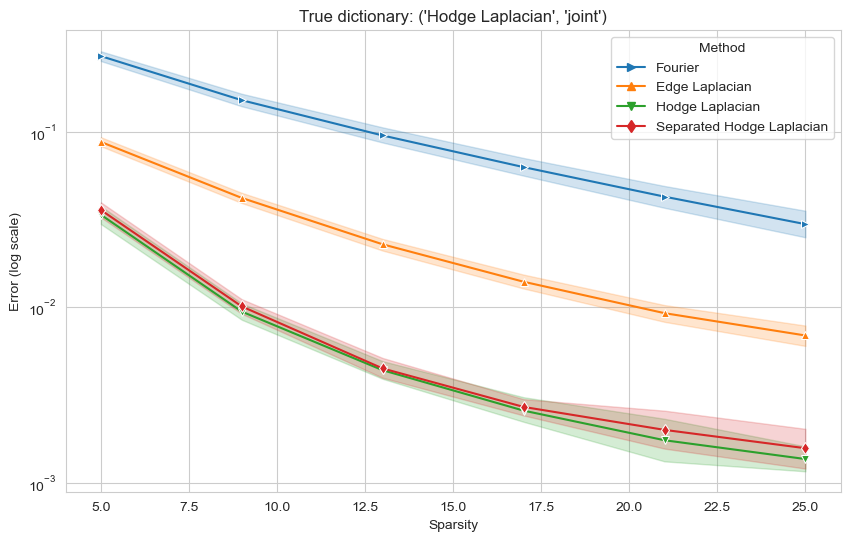

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

TITLE = [dict_types[typ] for typ in dict_types.keys() if typ in dictionary_type][0]

res_df = pd.DataFrame()
dict_types = {"fou": "Fourier", "edge": "Edge Laplacian", "joint": "Hodge Laplacian", "sep": "Separated Hodge Laplacian"}

for d in dict_types.items():
    for sim in range(n_sim):
        tmp_df = pd.DataFrame()   
        tmp_df["Error"] = eval(f'min_error_{d[0]}_test[sim,:]')
        tmp_df["Sparsity"] = K0_coll
        tmp_df["Method"] = d[1]
        res_df = pd.concat([res_df, tmp_df])

plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
my_plt = sns.lineplot(data=res_df, x='Sparsity', y='Error', hue='Method',
                       palette=sns.color_palette(),
                       markers=['>', '^', 'v', 'd'], dashes=False, style='Method')
my_plt.set(yscale='log')
my_plt.set_title(f'True dictionary: {TITLE}')
my_plt.set_ylabel('Error (log scale)')
plt.show()

# Save variables, plot and workspace

In [30]:
import pickle
import os
import dill

save_var = {"min_error_edge_test":min_error_edge_test,
            "min_error_edge_train":min_error_edge_train,
            "min_error_fou_test":min_error_fou_test,
            "min_error_fou_train":min_error_fou_train,
            "min_error_joint_test":min_error_joint_test,
            "min_error_joint_train":min_error_joint_train,
            "min_error_sep_test":min_error_sep_test,
            "min_error_sep_train":min_error_sep_train}

PATH = os.getcwd()
DIR_PATH = f'{PATH}\\results\\{dictionary_type}'
FILENAME_ERR = f'{DIR_PATH}\\error.pkl'
FILENAME_ENV = f'{DIR_PATH}\\ipynb_env.db'
FILENAME_PLT = f'{DIR_PATH}\\plot.png'

if not os.path.exists(DIR_PATH):
    os.makedirs(DIR_PATH)
    
with open(FILENAME_ERR, 'wb') as f: 
    pickle.dump(save_var, f)
f.close()

dill.dump_session(FILENAME_ENV)

fig = my_plt.get_figure()
fig.savefig(FILENAME_PLT)

# Vettorizzazione for esterni

In [ ]:
# import scipy.io
# mat = scipy.io.loadmat('datiSC.mat')
# B1 = mat["B1"]
# B2 = mat["B2"]

# # Subsampling if needed to decrease complexity
# sub_size = 100
# B1 = B1[:, :sub_size]
# B2 = B2[:sub_size, :]
# B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# # Laplacians
# Ld = np.matmul(np.transpose(B1), B1, dtype=float)
# Lu = np.matmul(B2, np.transpose(B2), dtype=float)
# L = Lu+Ld
# n =  L.shape[0]
# nu = B2.shape[1]
# nd = B1.shape[1]
# _ ,U = la.eig(L)

# # Problem and Dictionary Dimensionalities
# dictionary_type_true = "separated"
# m_train = 150 # Number of Train Signals
# m_test = 80 # Number of Test Signal
# s_true = 3 # Number of Kernels (Sub-dictionaries)
# k_true = 2 # Polynomial order
# sparsity = .1 # Sparsity percentage
# K0_max = 20 #floor(n*sparsity) # Sparsity
# sparsity_mode = "max"

# # Data-Independent Problem Hyperparameters
# dictionary_type = dictionary_type_true
# s = s_true
# k = k_true
# K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
# lambda_ = 1e-6 # l2 multiplier
# max_iter = 100 # Maximum number of iterations
# patience = 5 # Patience
# tol = 1e-7 # Tolerance for Patience
# n_sim = 10
# verbose = 0
# # for sim in range(5,n_sim):
# tmp_res = pd.DataFrame()
# def vectorized_generation(Lu,Ld,m_train,m_test,s, K, K0, dictionary_type, sparsity_mode):
#     D_try, h, Y_train_try, Y_test_try, epsilon_try, c_try, X_train_try, X_test_try = create_ground_truth(Lu,
#                                                                                 Ld,
#                                                                                 m_train,
#                                                                                 m_test, 
#                                                                                 s=s, 
#                                                                                 K=K, 
#                                                                                 K0=K0, 
#                                                                                 dictionary_type=dictionary_type, 
#                                                                                 sparsity_mode=sparsity_mode)
#     res_dict ={"D_try":D_try,
#             "h":h,
#             "Y_train_try":Y_train_try,
#             "Y_test_try":Y_test_try,
#             "epsilon_try":epsilon_try,
#             "c_try":c_try,
#             "X_train_try":X_train_try,
#             "X_test_try":X_test_try}
#     return res_dict

# def vectorized_verify(row, K0_max, acc_tresh):
#     D_try=row["D_try"]
#     Y_train_try=row["Y_train_try"]
#     X_train_try=row["X_train_try"]
#     max_possible_sparsity, acc = verify_dic(D_try, Y_train_try, X_train_try, K0_max, acc_tresh)
#     row["acc"] = acc
#     row["max_s"] = max_possible_sparsity
#     return row

# tmp_res["search"] = np.arange(3000)
# tmp_res["res_dict"] = tmp_res.search.apply(lambda row: vectorized_generation(Lu,Ld,m_train,m_test,s=s, K=k, K0=K0_max, dictionary_type=dictionary_type, sparsity_mode=sparsity_mode))
# tmp_res["res_dict"] = tmp_res.res_dict.apply(lambda row:  vectorized_verify(row, K0_max, 0.7))